## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2         # using opencv to read images
import os
import tifffile    # stacked images format .tiff
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.models import Model
from tensorflow.keras.layers import Flatten
from keras.models import load_model
from tensorflow import keras
os.environ['CUDA_VISIBLE_DEVICES'] = ''

2023-05-14 10:28:48.024398: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 10:28:49.016772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
directory = "./complete_ms_data"

In [3]:
path = os.listdir(directory)

# Data Preprocessing

In [4]:
img_directory = {}
folder = []
    #using os.walk
for root, dirs, folder in os.walk(directory):         
    dir_name = os.path.basename(root)
    img_directory[dir_name] = [root + '/' + file for file in folder]

key = list(img_directory.keys())[0]
img_directory.pop(key)

for key, value in img_directory.items():
    img_directory[key] = [v for v in value if "png" in v] 

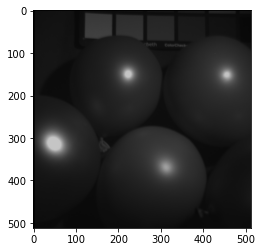

In [5]:
img = cv2.imread('./complete_ms_data/balloons_ms/balloons_ms/balloons_ms_01.png')
img.shape
plt.imshow(img)

## Stacking Images

In [6]:
msi = {}
for img_name, direct in img_directory.items():
    print(img_name)
    images = [cv2.imread(img, 0) for img in direct]
    images = np.asarray(images)
    stacked_image = np.stack(images, axis=2)
    msi[img_name] = stacked_image

feathers_ms
face_ms
jelly_beans_ms
fake_and_real_sushi_ms
fake_and_real_peppers_ms
beads_ms
balloons_ms
paints_ms
chart_and_stuffed_toy_ms
real_and_fake_apples_ms
pompoms_ms
fake_and_real_beers_ms
oil_painting_ms
hairs_ms
cd_ms
egyptian_statue_ms
flowers_ms
cloth_ms
watercolors_ms
fake_and_real_tomatoes_ms
clay_ms
fake_and_real_food_ms
real_and_fake_peppers_ms
glass_tiles_ms
fake_and_real_lemons_ms
fake_and_real_lemon_slices_ms
superballs_ms
thread_spools_ms
stuffed_toys_ms
fake_and_real_strawberries_ms
sponges_ms
photo_and_face_ms


# Patches

In [7]:
def patch_all(multi_spec,filterdim1,filterdim2,stride):

  g_patches = []

  for key, value in multi_spec.items():
      #print(key)
      img_shape = multi_spec[key].shape
      width, height = img_shape[1], img_shape[0]
      
      for row in range(height // filterdim1):
          for col in range(width // filterdim2):
              img_patch = value[row*64:(row+1)*64, col*64:(col+1)*64, 0:stride]
              g_patches.append(img_patch)
  return g_patches

In [8]:
patches = patch_all(msi,64,64,31)
print("length of patches =",len(patches))

length of patches = 2048


## Labelling data

In [9]:
y = np.asarray(patches)
y = y.astype(float)
print("Label y =",y.shape)

Label y = (2048, 64, 64, 31)


## Feature x_a = (8, 8, 31)

In [10]:
x_a = tf.keras.layers.AveragePooling2D(pool_size=(8, 8),strides=(8, 8), padding='valid',dtype='float64')
x_a = x_a(y)
print("x_a =",x_a.shape)

2023-05-14 10:29:19.063495: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-14 10:29:19.063553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pop-os
2023-05-14 10:29:19.063559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pop-os
2023-05-14 10:29:19.063743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.105.17
2023-05-14 10:29:19.063773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.105.17
2023-05-14 10:29:19.063777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.105.17
2023-05-14 10:29:19.067846: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2080374784 exceeds 10% of free s

x_a = (2048, 8, 8, 31)


## Feature x_b = (64, 64, 3)

In [11]:
xb1 = y[:,:,:,0:11].mean(axis = 3)
xb2 = y[:,:,:,10:21].mean(axis = 3)
xb3 = y[:,:,:,20:].mean(axis = 3)
print("Shape of xb1 =",xb1.shape,"\nShape of xb2 =", xb2.shape,"\nShape of xb3 =", xb3.shape)

x_b = np.stack([xb1, xb2, xb3], axis=3)                  
print('\nx_b =', x_b.shape)

Shape of xb1 = (2048, 64, 64) 
Shape of xb2 = (2048, 64, 64) 
Shape of xb3 = (2048, 64, 64)

x_b = (2048, 64, 64, 3)


In [12]:
print("Labels y = ", y.shape)
print("\nFeature x_a = ",x_a.shape)
print("Feature x_b = ",x_b.shape)

Labels y =  (2048, 64, 64, 31)

Feature x_a =  (2048, 8, 8, 31)
Feature x_b =  (2048, 64, 64, 3)


## Data Normalization

In [13]:
x_a = np.array(x_a)
x_b = np.array(x_b)
y = np.array(y)

In [14]:
x_a = x_a/255
x_b = x_b/255               
y = y/255

In [15]:
print("x_a =",x_a.shape)
print("x_b =",x_b.shape)
print("y =",y.shape)

x_a = (2048, 8, 8, 31)
x_b = (2048, 64, 64, 3)
y = (2048, 64, 64, 31)


## Train, Test, Split

In [16]:
X_train_a, X_test_a, X_train_b, X_test_b, y_train, y_test = train_test_split(x_a, x_b, y, test_size=0.2)

In [17]:
print("X_train_a shape:", X_train_a.shape)
print("X_test_a shape:", X_test_a.shape)
print("X_train_b shape:", X_train_b.shape)
print("X_test_b shape:", X_test_b.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_a shape: (1638, 8, 8, 31)
X_test_a shape: (410, 8, 8, 31)
X_train_b shape: (1638, 64, 64, 3)
X_test_b shape: (410, 64, 64, 3)
y_train shape: (1638, 64, 64, 31)
y_test shape: (410, 64, 64, 31)


## Model

In [18]:

def _phase_shift(I, r):
    bsize, w, h, c = I.get_shape().as_list()
    bsize = tf.shape(I)[0]
    X = tf.reshape(I, (bsize, w, h, r, r))
    X = tf.split(X, w, 1)
    X = tf.concat([tf.squeeze(x, axis=1) for x in X], 2)
    X = tf.split(X, h, 1)
    X = tf.concat([tf.squeeze(x, axis=1) for x in X], 2)

    return tf.reshape(X, (bsize, w * r, h * r, 1))


def PixelShuffle(X, r):
    Xc = tf.split(X, 31, 3)
    X = tf.concat([_phase_shift(x, r) for x in Xc], 3)
    return X



In [19]:
image_size = 64
bands = 31 
num_spectral=31 
num_res=6
num_fm=64
weight_decay = 1e-4



# Channel Attention
ms = tf.keras.Input(shape=(8, 8, 31))
RGB = tf.keras.Input(shape=(64, 64, 3))


ms_copy = tf.keras.layers.Conv2D(num_spectral * 8 * 8, kernel_size=1, strides=1, activation=tf.nn.leaky_relu,
                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                            kernel_initializer=tf.keras.initializers.VarianceScaling(),
                            padding='same')(ms)


ms_copy = PixelShuffle(ms_copy, 8)




gap_ms_c = tf.reduce_mean(ms, axis=[1, 2], keepdims=True)
CA = tf.keras.layers.Conv2D(1, kernel_size=1, strides=1, activation=tf.nn.leaky_relu,
                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                            kernel_initializer=tf.keras.initializers.VarianceScaling())(gap_ms_c)
CA = tf.keras.layers.Conv2D(num_spectral, kernel_size=1, strides=1, activation=tf.nn.sigmoid,
                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                            kernel_initializer=tf.random_normal_initializer())(CA)



# Spatial Attention
gap_RGB_s = tf.reduce_mean(RGB, axis=3, keepdims=True)
SA = tf.keras.layers.Conv2D(1, kernel_size=6, strides=1, activation=tf.nn.sigmoid,
                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                            kernel_initializer=tf.keras.initializers.VarianceScaling(),
                            padding='same')(gap_RGB_s)



# Downsampled RGB
rgb = tf.keras.layers.Conv2D(3, kernel_size=10, strides=7, activation=None,
                              kernel_initializer=tf.keras.initializers.VarianceScaling(),
                              kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(RGB)



rslice, gslice, bslice = tf.split(rgb, 3, axis=3)
msp1, msp2 = tf.split(ms, [15, 16], axis=3)
ms_new = tf.concat([rslice, msp1, gslice, msp2, bslice], axis=3)

rs = tf.keras.layers.Conv2D(num_spectral * 8 * 8, kernel_size=3, strides=1, activation=tf.nn.leaky_relu,
                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                            kernel_initializer=tf.keras.initializers.VarianceScaling(),
                            padding='same')(ms_new)
rs = PixelShuffle(rs, 8)
Rslice, Gslice, Bslice = tf.split(RGB, 3, axis=3)
Msp1, Msp2 = tf.split(rs, [15, 16], axis=3)
rs = tf.concat([Rslice, Msp1, Gslice, Msp2, Bslice], axis=3)
rs = tf.keras.layers.Conv2D(num_fm, kernel_size=3, strides=1, activation=tf.nn.leaky_relu,
                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                            kernel_initializer=tf.keras.initializers.VarianceScaling(),
                            padding='same')(rs)



# ResNet Blocks
for _ in range(num_res):
    rs1 = tf.keras.layers.Conv2D(num_fm, kernel_size=3, strides=1, activation=tf.nn.leaky_relu,
                                  kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                  kernel_initializer=tf.keras.initializers.VarianceScaling(),
                                 padding='same')(rs)
    rs1 = tf.keras.layers.Conv2D(num_fm, kernel_size=3, strides=1, activation=None,
                                  kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                                  kernel_initializer=tf.keras.initializers.VarianceScaling(),
                                 padding='same')(rs1)
    rs = tf.add(rs, rs1)



rs = SA * rs
rs = tf.keras.layers.Conv2D(num_spectral, kernel_size=3, strides=1, activation=None,
                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                            kernel_initializer=tf.keras.initializers.VarianceScaling(),
                            padding='same')(rs)
rs = CA * rs

reconstructed_ms = tf.keras.layers.Add()([rs, ms_copy])


inputs = [ms, RGB]
outputs = reconstructed_ms
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

In [21]:
history = model.fit(x=[X_train_a, X_train_b], y=y_train, epochs=100, batch_size=32, validation_data=([X_test_a, X_test_b], y_test))

Epoch 1/100


2023-05-14 10:30:00.622510: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 831946752 exceeds 10% of free system memory.


52/52 [==============================] - 190s 3s/step - loss: 0.4874 - val_loss: 0.4636
Epoch 2/100
52/52 [==============================] - 147s 3s/step - loss: 0.4436 - val_loss: 0.4242
Epoch 3/100
52/52 [==============================] - 147s 3s/step - loss: 0.4064 - val_loss: 0.3895
Epoch 4/100
52/52 [==============================] - 146s 3s/step - loss: 0.3735 - val_loss: 0.3586
Epoch 5/100
52/52 [==============================] - 146s 3s/step - loss: 0.3441 - val_loss: 0.3306
Epoch 6/100
52/52 [==============================] - 145s 3s/step - loss: 0.3175 - val_loss: 0.3054
Epoch 7/100
52/52 [==============================] - 144s 3s/step - loss: 0.2936 - val_loss: 0.2829
Epoch 8/100
52/52 [==============================] - 145s 3s/step - loss: 0.2722 - val_loss: 0.2627
Epoch 9/100
52/52 [==============================] - 144s 3s/step - loss: 0.2528 - val_loss: 0.2442
Epoch 10/100
52/52 [==============================] - 144s 3s/step - loss: 0.2353 - val_loss: 0.2274
Epoch 11/10

## Plotting Loss

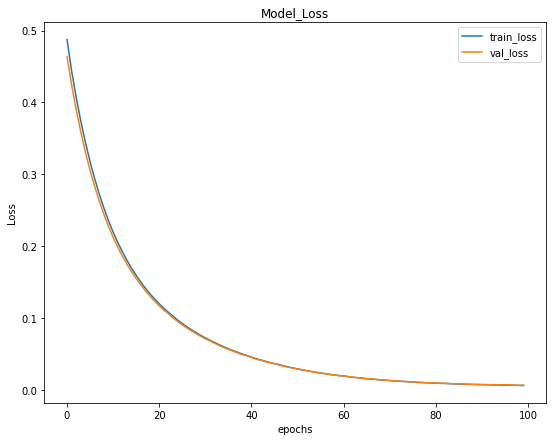

In [22]:
plt.figure(figsize=(9,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['train_loss','val_loss'], loc='upper right')
plt.show()

In [23]:
model.save('./super_res_model3.h5')

In [24]:
# model = tf.keras.models.load_model('./drive/MyDrive/super_res_model2.h5')
y_hat = model.predict([x_a, x_b])
y_hat.shape

64/64 [==============================] - 32s 473ms/step


2023-05-14 14:33:05.054196: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1040187392 exceeds 10% of free system memory.


(2048, 64, 64, 31)

In [25]:
y_hat = y_hat * 255

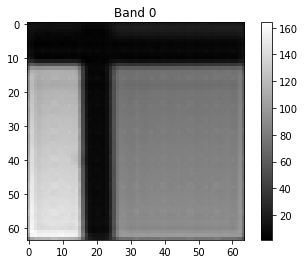

In [26]:
band_index = 0
band = y_hat[1,:, :, band_index]

# Plot the image
plt.imshow(band, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.title("Band {}".format(band_index))
plt.colorbar()
plt.show()

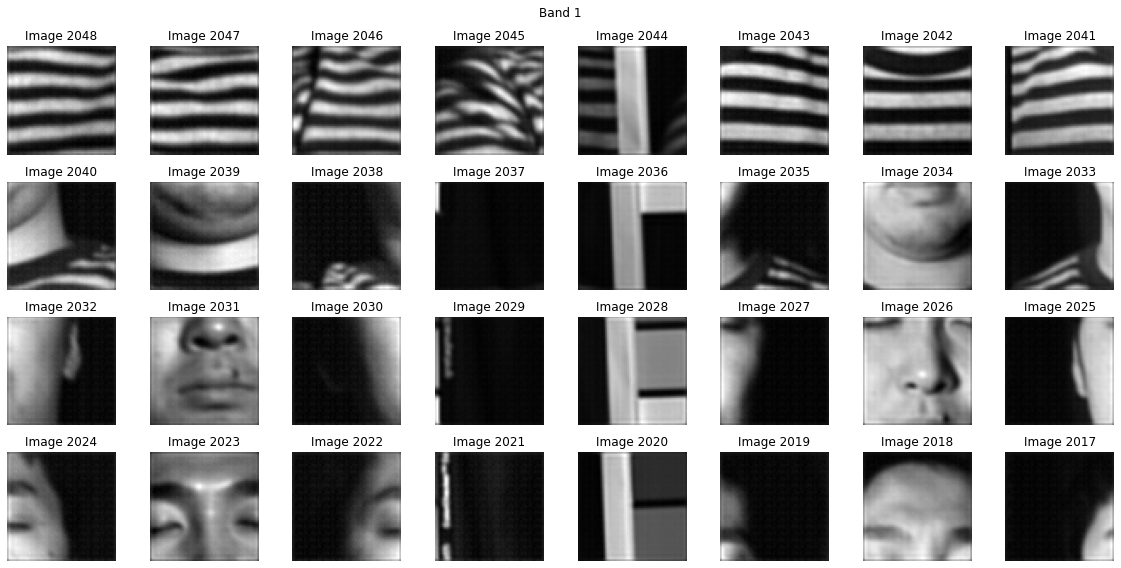

In [58]:
band_index = 2 

fig, axs = plt.subplots(4, 8, figsize=(16, 8))
axs = axs.flatten()
j = y_hat.shape[0]-1
for i in range(32):
    axs[i].imshow(y_hat[j, :, :, band_index],cmap='gray')
    axs[i].set_title("Image {}".format(j + 1))
    axs[i].axis('off')
    j = j-1

plt.suptitle("Band 1")
plt.tight_layout()
plt.show()

In [28]:
y = y * 255

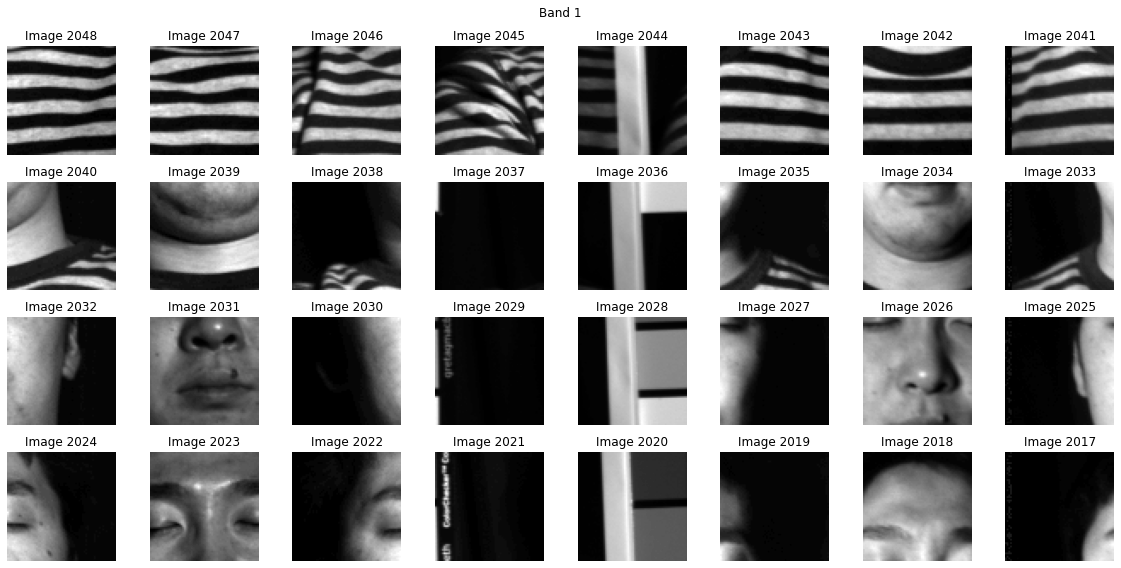

In [29]:
band_index = 0  

fig, axs = plt.subplots(4, 8, figsize=(16, 8))
axs = axs.flatten()
j = y.shape[0]-1
for i in range(32):
    axs[i].imshow(y[j, :, :, band_index],cmap='gray')
    axs[i].set_title("Image {}".format(j + 1))
    axs[i].axis('off')
    j = j-1

plt.suptitle("Band 1")
plt.tight_layout()
plt.show()